# User Latent Dirichlet Allocation

In [24]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
sys.path.append(os.path.abspath('../../vae_playground'))
sys.path.append(os.path.abspath('..'))

In [25]:
%load_ext autoreload
%autoreload 2

from lib.models import InductiveLDA as InductiveLDA

from sklearn.cluster import KMeans

import vae_playground.datasets as datasets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import Data

In [26]:
DATASET_NAME = 'goi4_dp_small'
RANDOM_SEED = 2112
np.random.seed(RANDOM_SEED)

In [27]:
df = pd.read_csv(f'../data/{DATASET_NAME}/dataset.csv')
data, dates, users = df.iloc[:,:-2].values, df.date.values, df.user.values
date_ids, user_ids = df.date.unique(), df.user.unique()
num_days, num_users = len(date_ids), len(user_ids)
print(f'Loaded {len(data)} consumption profiles from {num_days} dates and {num_users} users')

Loaded 631815 consumption profiles from 365 dates and 1731 users


In [28]:
RESOLUTION = 1 #in hours

if RESOLUTION == 12:
    X = torch.tensor(data, dtype=torch.float32).reshape(-1, 24)
    #circle shift the last dimension of X
    X = torch.cat([X[:,6:], X[:,:6]], dim=-1).reshape(num_users, num_days, int(24/RESOLUTION), int(RESOLUTION)).sum(dim=-1)
else:
    X = torch.tensor(data, dtype=torch.float32).reshape(num_users, num_days, int(24/RESOLUTION), int(RESOLUTION)).sum(dim=-1)
dates, users = np.reshape(dates, (num_users, num_days)), np.reshape(users, (num_users, num_days))

In [29]:
# Remove users with all-zero consumption profiles
nonzero_user_mask = torch.sum(torch.all(X == 0, dim=2), dim=1) < num_days
print(f'Removing {(~nonzero_user_mask).sum()} users with all-zero consumption profiles')
positive_user_mask = torch.sum(torch.any(X < 0, dim=2), dim=1) == 0
print(f'Removing {(~positive_user_mask).sum()} users with any-negative consumption profiles')
user_mask = nonzero_user_mask & positive_user_mask

Removing 4 users with all-zero consumption profiles
Removing 18 users with any-negative consumption profiles


In [30]:
X = X[user_mask]
dates, users = dates[user_mask], users[user_mask]
user_ids = user_ids[user_mask]

In [31]:
USER_SUBSAMPLE_RATE = 1
DAY_SUBSAMPLE_RATE = 1
X = X[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :]
num_users, num_days, num_features = X.shape
X = X.flatten(end_dim=1)
print(f"Number of (subsampled/filtered) users: {num_users}")
print(f"Number of (subsampled) days: {num_days}")
print(f"Number of (aggregated) features: {num_features}")

Number of (subsampled/filtered) users: 1709
Number of (subsampled) days: 365
Number of (aggregated) features: 24


In [32]:
nonzero_mean, nonzero_std = datasets.zero_preserved_log_stats(X)
X_norm = datasets.zero_preserved_log_normalize(X, nonzero_mean, nonzero_std).reshape(num_users, num_days, num_features)
dataset = datasets.UserDayDataset(X_norm)
X_flt = dataset.flatten_inputs
user_idx, day_idx = dataset.user_day_list[:,0], dataset.user_day_list[:,1]

In [33]:
df_plt = pd.DataFrame(torch.cat((X_flt, user_idx.unsqueeze(1), day_idx.unsqueeze(1)), dim=-1))
df_plt.columns = [f'feature_{i}' for i in range(num_features)] + ['user'] + ['day']

In [34]:
if num_users <= 100 and num_features == 2:
    sns.scatterplot(df_plt, x="feature_0", y="feature_1", hue='user', palette="Set1", alpha=.5)
    # move the legend outside
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='user', ncol=5)
    plt.xlabel('Diurnal consumption')
    plt.ylabel('Nocturnal consumption')
    plt.show()

In [35]:
n_bins = 100
kmeans = KMeans(n_clusters=n_bins, random_state=RANDOM_SEED, n_init='auto').fit(X_flt)

In [36]:
labels = kmeans.labels_
labels_onehot = np.zeros((len(labels), len(set(labels))))
labels_onehot[np.arange(len(labels)), labels] = 1
X_words = torch.tensor(labels_onehot).reshape(num_users, num_days, -1)

In [37]:
DOC_TYPE = "day"       # "day" or "user"

if DOC_TYPE == "day":
    X_document, num_words = X_words.sum(dim=0), num_users
elif DOC_TYPE == "user":
    X_document, num_words = X_words.sum(dim=1), num_days
else:
    raise ValueError(f"Invalid DOC_TYPE: {DOC_TYPE}")

num_docs, dict_size = X_document.shape[0], n_bins

In [38]:
if dict_size <= 50 and num_features == 2:
    df_plt = pd.DataFrame(torch.cat((X_flt,torch.tensor(labels).unsqueeze(1)), dim=-1))
    df_plt.columns = [f'feature_{i}' for i in range(num_features)] + ['word']
    sns.scatterplot(df_plt, x="feature_0", y="feature_1", hue='word', palette="Set2", alpha=.5)
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x', s=100, c='black')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='word_id', ncol=5)
    plt.xlabel('Diurnal consumption')
    plt.ylabel('Nocturnal consumption')
    plt.show()

In [39]:
X_labels = torch.tensor(labels).reshape(num_users, num_days)
if DOC_TYPE == "day": X_labels = X_labels.T

In [40]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X): self.X = X
    def __len__(self): return len(self.X)
    def __getitem__(self, index): return self.X[index]

In [41]:
dataset = Dataset(X_document.to(torch.float32))

In [42]:
# Set training parameters.
num_topics = 10
prodlda = False
conv = False
num_layers = 2
num_neurons = 200

In [43]:
model = InductiveLDA(input_dim=n_bins,
                    num_topics=num_topics, 
                    conv=conv,
                    prodlda=prodlda,
                    num_hidden_layers=num_layers,
                    num_neurons=num_neurons,
                    )

In [44]:
lr = 1e-3
batch_size = 32
num_epochs = 1000
beta = 1
learn_prior = False
prior_params = {'alpha': 1.0}

In [45]:
# Train the model using default partitioning choice 
model.train(lr=lr,
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True),
            num_epochs = num_epochs,
            beta = beta,
            prior_params = prior_params,
            mc_samples = 1,
            learn_prior = learn_prior,
            tensorboard = False,
            )

Epoch:   1%|          | 8/1000 [00:00<01:04, 15.38it/s]

                                                  


                                                                  
                                                       


Epoch:   1%|          | 12/1000 [00:00<01:08, 14.45it/s]

Iteration: 100 -- ELBO=-7.85e+03 / RLL=-7.83e+03 / KL=1.62e+01


Epoch:   2%|▏         | 16/1000 [00:01<01:10, 14.06it/s]

                                                  


                                                                  
                                                               


Epoch:   2%|▏         | 20/1000 [00:01<01:31, 10.73it/s]

Iteration: 200 -- ELBO=-7.76e+03 / RLL=-7.75e+03 / KL=1.77e+01


Epoch:   2%|▏         | 24/1000 [00:01<01:21, 11.91it/s]

                                                  


                                                                  
                                                       


Epoch:   3%|▎         | 28/1000 [00:02<01:16, 12.78it/s]

Iteration: 300 -- ELBO=-7.72e+03 / RLL=-7.71e+03 / KL=1.86e+01


Epoch:   3%|▎         | 34/1000 [00:02<01:11, 13.58it/s]

                                                  


                                                                  
                                                       


Epoch:   4%|▎         | 36/1000 [00:02<01:13, 13.14it/s]

Iteration: 400 -- ELBO=-7.63e+03 / RLL=-7.61e+03 / KL=1.88e+01


Epoch:   4%|▍         | 42/1000 [00:03<01:09, 13.71it/s]

                                                  


                                                                  
                                                       


Epoch:   4%|▍         | 44/1000 [00:03<01:12, 13.27it/s]

Iteration: 500 -- ELBO=-7.59e+03 / RLL=-7.57e+03 / KL=1.90e+01


Epoch:   5%|▌         | 50/1000 [00:03<01:09, 13.66it/s]

                                                  


                                                                  
                                                       


Epoch:   5%|▌         | 52/1000 [00:03<01:10, 13.49it/s]

Iteration: 600 -- ELBO=-7.55e+03 / RLL=-7.53e+03 / KL=1.84e+01


Epoch:   6%|▌         | 58/1000 [00:04<01:08, 13.67it/s]

                                                  


                                                                  
                                                       


Epoch:   6%|▌         | 62/1000 [00:04<01:08, 13.63it/s]

Iteration: 700 -- ELBO=-7.53e+03 / RLL=-7.51e+03 / KL=1.85e+01


Epoch:   7%|▋         | 66/1000 [00:04<01:07, 13.78it/s]

                                                  


                                                                  
                                                       


Epoch:   7%|▋         | 70/1000 [00:05<01:08, 13.65it/s]

Iteration: 800 -- ELBO=-7.50e+03 / RLL=-7.48e+03 / KL=1.82e+01


Epoch:   7%|▋         | 74/1000 [00:05<01:06, 13.87it/s]

                                                  


                                                                  
                                                       


Epoch:   8%|▊         | 78/1000 [00:05<01:06, 13.78it/s]

Iteration: 900 -- ELBO=-7.45e+03 / RLL=-7.43e+03 / KL=1.85e+01


Epoch:   8%|▊         | 84/1000 [00:06<01:07, 13.62it/s]

                                                  


                                                                  
                                                       


Epoch:   9%|▊         | 86/1000 [00:06<01:11, 12.85it/s]

Iteration: 1000 -- ELBO=-7.44e+03 / RLL=-7.42e+03 / KL=1.82e+01


Epoch:   9%|▉         | 92/1000 [00:06<01:08, 13.25it/s]

                                                  


                                                                  
                                                       


Epoch:   9%|▉         | 94/1000 [00:07<01:11, 12.58it/s]

Iteration: 1100 -- ELBO=-7.43e+03 / RLL=-7.41e+03 / KL=1.79e+01


Epoch:  10%|█         | 100/1000 [00:07<01:09, 13.00it/s]

                                                  


                                                                  
                                                       


Epoch:  10%|█         | 102/1000 [00:07<01:11, 12.54it/s]

Iteration: 1200 -- ELBO=-7.37e+03 / RLL=-7.36e+03 / KL=1.83e+01


Epoch:  11%|█         | 108/1000 [00:08<01:08, 12.99it/s]

                                                  


                                                                  
                                                       


Epoch:  11%|█         | 110/1000 [00:08<01:11, 12.49it/s]

Iteration: 1300 -- ELBO=-7.39e+03 / RLL=-7.38e+03 / KL=1.78e+01


Epoch:  12%|█▏        | 116/1000 [00:08<01:07, 13.03it/s]

                                                  


                                                                  
                                                       


Epoch:  12%|█▏        | 120/1000 [00:09<01:08, 12.78it/s]

Iteration: 1400 -- ELBO=-7.32e+03 / RLL=-7.30e+03 / KL=1.78e+01


Epoch:  12%|█▏        | 124/1000 [00:09<01:07, 12.93it/s]

                                                  


                                                                  
                                                       


Epoch:  13%|█▎        | 128/1000 [00:09<01:08, 12.73it/s]

Iteration: 1500 -- ELBO=-7.39e+03 / RLL=-7.37e+03 / KL=1.76e+01


Epoch:  13%|█▎        | 134/1000 [00:10<01:06, 12.95it/s]

                                                  


                                                                  
                                                       


Epoch:  14%|█▎        | 136/1000 [00:10<01:09, 12.47it/s]

Iteration: 1600 -- ELBO=-7.32e+03 / RLL=-7.30e+03 / KL=1.75e+01


Epoch:  14%|█▍        | 142/1000 [00:10<01:06, 12.99it/s]

                                                  


                                                                  
                                                       


Epoch:  14%|█▍        | 144/1000 [00:11<01:07, 12.65it/s]

Iteration: 1700 -- ELBO=-7.32e+03 / RLL=-7.30e+03 / KL=1.74e+01


Epoch:  15%|█▌        | 150/1000 [00:11<01:02, 13.68it/s]

                                                  


                                                                  
                                                       


Epoch:  15%|█▌        | 152/1000 [00:11<01:02, 13.60it/s]

Iteration: 1800 -- ELBO=-7.34e+03 / RLL=-7.32e+03 / KL=1.71e+01


Epoch:  16%|█▌        | 158/1000 [00:12<01:00, 13.83it/s]

                                                  


                                                                  
                                                       


Epoch:  16%|█▌        | 160/1000 [00:12<01:02, 13.45it/s]

Iteration: 1900 -- ELBO=-7.32e+03 / RLL=-7.30e+03 / KL=1.71e+01


Epoch:  17%|█▋        | 166/1000 [00:12<01:01, 13.58it/s]

                                                  


                                                                  
                                                       


Epoch:  17%|█▋        | 170/1000 [00:12<01:02, 13.37it/s]

Iteration: 2000 -- ELBO=-7.29e+03 / RLL=-7.27e+03 / KL=1.70e+01


Epoch:  17%|█▋        | 174/1000 [00:13<01:00, 13.60it/s]

                                                  


                                                                  
                                                       


Epoch:  18%|█▊        | 178/1000 [00:13<01:01, 13.27it/s]

Iteration: 2100 -- ELBO=-7.45e+03 / RLL=-7.43e+03 / KL=1.57e+01


Epoch:  18%|█▊        | 184/1000 [00:13<00:59, 13.77it/s]

                                                  


                                                                  
                                                       


Epoch:  19%|█▊        | 186/1000 [00:14<01:00, 13.50it/s]


Iteration: 2200 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=1.66e+01


Epoch:  19%|█▉        | 192/1000 [00:14<00:58, 13.86it/s]]

                                                  


                                                                  
                                                       


Epoch:  19%|█▉        | 194/1000 [00:14<01:01, 13.21it/s]

Iteration: 2300 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=1.64e+01


Epoch:  20%|██        | 200/1000 [00:15<01:00, 13.21it/s]

                                                  


                                                                  
                                                       


Epoch:  20%|██        | 202/1000 [00:15<01:02, 12.70it/s]

Iteration: 2400 -- ELBO=-7.33e+03 / RLL=-7.31e+03 / KL=1.58e+01


Epoch:  21%|██        | 208/1000 [00:15<01:01, 12.93it/s]

                                                  


                                                                  
                                                       


Epoch:  21%|██        | 210/1000 [00:15<01:03, 12.43it/s]

Iteration: 2500 -- ELBO=-7.31e+03 / RLL=-7.30e+03 / KL=1.55e+01


Epoch:  22%|██▏       | 216/1000 [00:16<01:00, 13.04it/s]

                                                  


                                                                   
                                                       


Epoch:  22%|██▏       | 220/1000 [00:16<01:00, 12.87it/s]

Iteration: 2600 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=1.57e+01


Epoch:  22%|██▏       | 224/1000 [00:17<01:00, 12.89it/s]

                                                  


                                                                   
                                                       


Epoch:  23%|██▎       | 228/1000 [00:17<01:00, 12.75it/s]

Iteration: 2700 -- ELBO=-7.34e+03 / RLL=-7.32e+03 / KL=1.55e+01


Epoch:  23%|██▎       | 234/1000 [00:17<00:58, 13.17it/s]

                                                  


                                                                   
                                                       


Epoch:  24%|██▎       | 236/1000 [00:18<01:00, 12.57it/s]

Iteration: 2800 -- ELBO=-7.30e+03 / RLL=-7.28e+03 / KL=1.54e+01


Epoch:  24%|██▍       | 242/1000 [00:18<00:57, 13.18it/s]

                                                  


                                                                   
                                                       


Epoch:  24%|██▍       | 244/1000 [00:18<00:57, 13.11it/s]

Iteration: 2900 -- ELBO=-7.24e+03 / RLL=-7.22e+03 / KL=1.59e+01


Epoch:  25%|██▌       | 250/1000 [00:19<00:54, 13.71it/s]

                                                  


                                                                   
                                                       


Epoch:  25%|██▌       | 252/1000 [00:19<00:55, 13.50it/s]

Iteration: 3000 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=1.51e+01


Epoch:  26%|██▌       | 258/1000 [00:19<00:53, 13.87it/s]

                                                  


                                                                   
                                                       


Epoch:  26%|██▌       | 262/1000 [00:19<00:53, 13.84it/s]

Iteration: 3100 -- ELBO=-7.29e+03 / RLL=-7.28e+03 / KL=1.50e+01


Epoch:  27%|██▋       | 266/1000 [00:20<00:52, 13.85it/s]

                                                  


                                                                   
                                                       


Epoch:  27%|██▋       | 270/1000 [00:20<00:51, 14.19it/s]

Iteration: 3200 -- ELBO=-7.25e+03 / RLL=-7.24e+03 / KL=1.46e+01


Epoch:  27%|██▋       | 274/1000 [00:20<00:52, 13.95it/s]

                                                  


                                                                   
                                                       


Epoch:  28%|██▊       | 278/1000 [00:21<00:54, 13.24it/s]

Iteration: 3300 -- ELBO=-7.25e+03 / RLL=-7.24e+03 / KL=1.46e+01


Epoch:  28%|██▊       | 284/1000 [00:21<00:53, 13.47it/s]

                                                  


                                                                   
                                                       


Epoch:  29%|██▊       | 286/1000 [00:21<00:55, 12.86it/s]

Iteration: 3400 -- ELBO=-7.28e+03 / RLL=-7.26e+03 / KL=1.46e+01


Epoch:  29%|██▉       | 292/1000 [00:22<00:53, 13.18it/s]

                                                  


                                                                   
                                                       


Epoch:  29%|██▉       | 294/1000 [00:22<00:56, 12.41it/s]

Iteration: 3500 -- ELBO=-7.25e+03 / RLL=-7.23e+03 / KL=1.46e+01


Epoch:  30%|███       | 300/1000 [00:22<00:52, 13.29it/s]

                                                  


                                                                   
                                                       


Epoch:  30%|███       | 302/1000 [00:22<00:53, 13.15it/s]

Iteration: 3600 -- ELBO=-7.22e+03 / RLL=-7.20e+03 / KL=1.42e+01


Epoch:  31%|███       | 308/1000 [00:23<00:50, 13.60it/s]

                                                  


                                                                   
                                                       


Epoch:  31%|███       | 312/1000 [00:23<00:49, 13.86it/s]

Iteration: 3700 -- ELBO=-7.28e+03 / RLL=-7.27e+03 / KL=1.40e+01


Epoch:  32%|███▏      | 316/1000 [00:23<00:49, 13.95it/s]

                                                  


                                                                   
                                                       


Epoch:  32%|███▏      | 320/1000 [00:24<00:49, 13.83it/s]

Iteration: 3800 -- ELBO=-7.22e+03 / RLL=-7.21e+03 / KL=1.40e+01


Epoch:  32%|███▏      | 324/1000 [00:24<00:49, 13.72it/s]

                                                  


                                                                   
                                                       


Epoch:  33%|███▎      | 328/1000 [00:24<00:50, 13.44it/s]

Iteration: 3900 -- ELBO=-7.26e+03 / RLL=-7.25e+03 / KL=1.40e+01


Epoch:  33%|███▎      | 334/1000 [00:25<00:47, 13.94it/s]

                                                  


                                                                   
                                                       


Epoch:  34%|███▎      | 336/1000 [00:25<00:50, 13.19it/s]

Iteration: 4000 -- ELBO=-7.22e+03 / RLL=-7.21e+03 / KL=1.42e+01


Epoch:  34%|███▍      | 342/1000 [00:25<00:47, 13.71it/s]

                                                  


                                                                   
                                                       


Epoch:  34%|███▍      | 344/1000 [00:26<00:48, 13.41it/s]

Iteration: 4100 -- ELBO=-7.22e+03 / RLL=-7.21e+03 / KL=1.41e+01


Epoch:  35%|███▌      | 350/1000 [00:26<00:46, 13.90it/s]

                                                  


                                                                   
                                                       


Epoch:  35%|███▌      | 352/1000 [00:26<00:48, 13.29it/s]

Iteration: 4200 -- ELBO=-7.29e+03 / RLL=-7.27e+03 / KL=1.38e+01


Epoch:  36%|███▌      | 358/1000 [00:27<00:47, 13.64it/s]

                                                  


                                                                   
                                                       


Epoch:  36%|███▌      | 362/1000 [00:27<00:46, 13.68it/s]

Iteration: 4300 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=1.37e+01


Epoch:  37%|███▋      | 366/1000 [00:27<00:46, 13.57it/s]

                                                  


                                                                   
                                                       


Epoch:  37%|███▋      | 370/1000 [00:27<00:48, 13.02it/s]

Iteration: 4400 -- ELBO=-7.28e+03 / RLL=-7.27e+03 / KL=1.37e+01


Epoch:  37%|███▋      | 374/1000 [00:28<00:48, 13.02it/s]

                                                  


                                                                   
                                                       


Epoch:  38%|███▊      | 378/1000 [00:28<00:48, 12.74it/s]

Iteration: 4500 -- ELBO=-7.20e+03 / RLL=-7.19e+03 / KL=1.38e+01


Epoch:  38%|███▊      | 384/1000 [00:29<00:45, 13.40it/s]

                                                  


                                                                   
                                                       


Epoch:  39%|███▊      | 386/1000 [00:29<00:48, 12.74it/s]

Iteration: 4600 -- ELBO=-7.26e+03 / RLL=-7.25e+03 / KL=1.35e+01


Epoch:  39%|███▉      | 392/1000 [00:29<00:45, 13.32it/s]

                                                  


                                                                   
                                                       


Epoch:  39%|███▉      | 394/1000 [00:29<00:48, 12.56it/s]

Iteration: 4700 -- ELBO=-7.21e+03 / RLL=-7.19e+03 / KL=1.35e+01


Epoch:  40%|████      | 400/1000 [00:30<00:46, 12.91it/s]

                                                  


                                                                   
                                                       


Epoch:  40%|████      | 402/1000 [00:30<00:47, 12.50it/s]

Iteration: 4800 -- ELBO=-7.31e+03 / RLL=-7.30e+03 / KL=1.33e+01


Epoch:  41%|████      | 408/1000 [00:30<00:45, 12.99it/s]

                                                  


                                                                   
                                                       


Epoch:  41%|████      | 410/1000 [00:31<00:47, 12.45it/s]

Iteration: 4900 -- ELBO=-7.21e+03 / RLL=-7.20e+03 / KL=1.37e+01


Epoch:  42%|████▏     | 416/1000 [00:31<00:45, 12.96it/s]

                                                  


                                                                   
                                                       


Epoch:  42%|████▏     | 420/1000 [00:31<00:45, 12.85it/s]

Iteration: 5000 -- ELBO=-7.23e+03 / RLL=-7.21e+03 / KL=1.33e+01


Epoch:  42%|████▏     | 424/1000 [00:32<00:43, 13.24it/s]

                                                  


                                                                   
                                                       


Epoch:  43%|████▎     | 428/1000 [00:32<00:41, 13.79it/s]

Iteration: 5100 -- ELBO=-7.25e+03 / RLL=-7.23e+03 / KL=1.36e+01


Epoch:  43%|████▎     | 434/1000 [00:32<00:40, 14.02it/s]

                                                  


                                                                   
                                                       


Epoch:  44%|████▎     | 436/1000 [00:33<00:41, 13.62it/s]

Iteration: 5200 -- ELBO=-7.26e+03 / RLL=-7.24e+03 / KL=1.35e+01


Epoch:  44%|████▍     | 442/1000 [00:33<00:41, 13.57it/s]

                                                  


                                                                   
                                                       


Epoch:  44%|████▍     | 444/1000 [00:33<00:42, 13.15it/s]

Iteration: 5300 -- ELBO=-7.27e+03 / RLL=-7.25e+03 / KL=1.33e+01


Epoch:  45%|████▌     | 450/1000 [00:34<00:40, 13.71it/s]

                                                  


                                                                   
                                                       


Epoch:  45%|████▌     | 452/1000 [00:34<00:41, 13.17it/s]

Iteration: 5400 -- ELBO=-7.14e+03 / RLL=-7.13e+03 / KL=1.35e+01


Epoch:  46%|████▌     | 458/1000 [00:34<00:39, 13.74it/s]

                                                  


                                                                   
                                                       


Epoch:  46%|████▌     | 462/1000 [00:34<00:39, 13.75it/s]

Iteration: 5500 -- ELBO=-7.23e+03 / RLL=-7.22e+03 / KL=1.36e+01


Epoch:  47%|████▋     | 466/1000 [00:35<00:38, 13.82it/s]

                                                  


                                                                   
                                                       


Epoch:  47%|████▋     | 470/1000 [00:35<00:37, 14.07it/s]

Iteration: 5600 -- ELBO=-7.29e+03 / RLL=-7.27e+03 / KL=1.29e+01


Epoch:  47%|████▋     | 474/1000 [00:35<00:37, 13.97it/s]

                                                  


                                                                   
                                                       


Epoch:  48%|████▊     | 478/1000 [00:36<00:39, 13.18it/s]

Iteration: 5700 -- ELBO=-7.22e+03 / RLL=-7.20e+03 / KL=1.32e+01


Epoch:  48%|████▊     | 484/1000 [00:36<00:38, 13.26it/s]

                                                  


                                                                   
                                                       


Epoch:  49%|████▊     | 486/1000 [00:36<00:40, 12.70it/s]

Iteration: 5800 -- ELBO=-7.21e+03 / RLL=-7.20e+03 / KL=1.34e+01


Epoch:  49%|████▉     | 492/1000 [00:37<00:39, 12.99it/s]

                                                  


                                                                   
                                                       


Epoch:  49%|████▉     | 494/1000 [00:37<00:40, 12.43it/s]

Iteration: 5900 -- ELBO=-7.20e+03 / RLL=-7.18e+03 / KL=1.31e+01


Epoch:  50%|█████     | 500/1000 [00:37<00:38, 12.96it/s]

                                                  


                                                                   
                                                       


Epoch:  50%|█████     | 502/1000 [00:38<00:39, 12.53it/s]

Iteration: 6000 -- ELBO=-7.27e+03 / RLL=-7.26e+03 / KL=1.26e+01


Epoch:  51%|█████     | 508/1000 [00:38<00:36, 13.38it/s]

                                                  


                                                                   
                                                       


Epoch:  51%|█████     | 512/1000 [00:38<00:35, 13.62it/s]

Iteration: 6100 -- ELBO=-7.21e+03 / RLL=-7.20e+03 / KL=1.27e+01


Epoch:  52%|█████▏    | 516/1000 [00:39<00:35, 13.61it/s]

                                                  


                                                                   
                                                       


Epoch:  52%|█████▏    | 520/1000 [00:39<00:35, 13.55it/s]

Iteration: 6200 -- ELBO=-7.20e+03 / RLL=-7.19e+03 / KL=1.29e+01


Epoch:  52%|█████▏    | 524/1000 [00:39<00:34, 13.70it/s]

                                                  


                                                                   
                                                       


Epoch:  53%|█████▎    | 528/1000 [00:39<00:34, 13.57it/s]

Iteration: 6300 -- ELBO=-7.22e+03 / RLL=-7.21e+03 / KL=1.29e+01


Epoch:  53%|█████▎    | 534/1000 [00:40<00:33, 13.92it/s]

                                                  


                                                                   
                                                       


Epoch:  54%|█████▎    | 536/1000 [00:40<00:34, 13.46it/s]

Iteration: 6400 -- ELBO=-7.27e+03 / RLL=-7.26e+03 / KL=1.28e+01


Epoch:  54%|█████▍    | 542/1000 [00:40<00:33, 13.86it/s]

                                                  


                                                                   
                                                       


Epoch:  54%|█████▍    | 544/1000 [00:41<00:33, 13.64it/s]

Iteration: 6500 -- ELBO=-7.24e+03 / RLL=-7.22e+03 / KL=1.26e+01


Epoch:  55%|█████▌    | 550/1000 [00:41<00:31, 14.21it/s]

                                                  


                                                                   
                                                       


Epoch:  55%|█████▌    | 552/1000 [00:41<00:32, 13.84it/s]

Iteration: 6600 -- ELBO=-7.18e+03 / RLL=-7.16e+03 / KL=1.25e+01


Epoch:  56%|█████▌    | 558/1000 [00:42<00:32, 13.69it/s]

                                                  


                                                                   
                                                       


Epoch:  56%|█████▌    | 560/1000 [00:42<00:34, 12.91it/s]

Iteration: 6700 -- ELBO=-7.24e+03 / RLL=-7.23e+03 / KL=1.24e+01


Epoch:  57%|█████▋    | 566/1000 [00:42<00:32, 13.18it/s]

                                                  


                                                                   
                                                       


Epoch:  57%|█████▋    | 570/1000 [00:43<00:33, 12.82it/s]

Iteration: 6800 -- ELBO=-7.19e+03 / RLL=-7.18e+03 / KL=1.24e+01


Epoch:  57%|█████▋    | 574/1000 [00:43<00:33, 12.89it/s]

                                                  


                                                                   
                                                       


Epoch:  58%|█████▊    | 578/1000 [00:43<00:32, 12.83it/s]

Iteration: 6900 -- ELBO=-7.23e+03 / RLL=-7.22e+03 / KL=1.25e+01


Epoch:  58%|█████▊    | 584/1000 [00:44<00:31, 13.11it/s]

                                                  


                                                                   
                                                       


Epoch:  59%|█████▊    | 586/1000 [00:44<00:32, 12.64it/s]

Iteration: 7000 -- ELBO=-7.21e+03 / RLL=-7.20e+03 / KL=1.26e+01


Epoch:  59%|█████▉    | 592/1000 [00:44<00:29, 13.62it/s]

                                                  


                                                                   
                                                       


Epoch:  59%|█████▉    | 594/1000 [00:44<00:31, 12.99it/s]

Iteration: 7100 -- ELBO=-7.24e+03 / RLL=-7.22e+03 / KL=1.27e+01


Epoch:  60%|██████    | 600/1000 [00:45<00:31, 12.87it/s]

                                                  


                                                                   
                                                       


Epoch:  60%|██████    | 602/1000 [00:45<00:31, 12.57it/s]

Iteration: 7200 -- ELBO=-7.28e+03 / RLL=-7.27e+03 / KL=1.17e+01


Epoch:  61%|██████    | 608/1000 [00:46<00:30, 12.92it/s]

                                                  


                                                                   
                                                       


Epoch:  61%|██████    | 610/1000 [00:46<00:31, 12.44it/s]

Iteration: 7300 -- ELBO=-7.22e+03 / RLL=-7.20e+03 / KL=1.22e+01


Epoch:  62%|██████▏   | 616/1000 [00:46<00:29, 12.94it/s]

                                                  


                                                                   
                                                       


Epoch:  62%|██████▏   | 620/1000 [00:47<00:29, 12.73it/s]

Iteration: 7400 -- ELBO=-7.26e+03 / RLL=-7.25e+03 / KL=1.22e+01


Epoch:  62%|██████▏   | 624/1000 [00:47<00:29, 12.96it/s]

                                                  


                                                                   
                                                       


Epoch:  63%|██████▎   | 628/1000 [00:47<00:29, 12.72it/s]

Iteration: 7500 -- ELBO=-7.22e+03 / RLL=-7.21e+03 / KL=1.25e+01


Epoch:  63%|██████▎   | 634/1000 [00:48<00:27, 13.08it/s]

                                                  


                                                                   
                                                       


Epoch:  64%|██████▎   | 636/1000 [00:48<00:28, 12.55it/s]

Iteration: 7600 -- ELBO=-7.21e+03 / RLL=-7.20e+03 / KL=1.22e+01


Epoch:  64%|██████▍   | 642/1000 [00:48<00:26, 13.56it/s]

                                                  


                                                                   
                                                       


Epoch:  64%|██████▍   | 644/1000 [00:48<00:26, 13.30it/s]

Iteration: 7700 -- ELBO=-7.22e+03 / RLL=-7.21e+03 / KL=1.22e+01


Epoch:  65%|██████▌   | 650/1000 [00:49<00:25, 13.72it/s]

                                                  


                                                                   
                                                       


Epoch:  65%|██████▌   | 652/1000 [00:49<00:26, 13.25it/s]

Iteration: 7800 -- ELBO=-7.16e+03 / RLL=-7.14e+03 / KL=1.19e+01


Epoch:  66%|██████▌   | 658/1000 [00:49<00:25, 13.66it/s]

                                                  


                                                                   
                                                       


Epoch:  66%|██████▌   | 662/1000 [00:50<00:24, 13.62it/s]

Iteration: 7900 -- ELBO=-7.23e+03 / RLL=-7.22e+03 / KL=1.16e+01


Epoch:  67%|██████▋   | 666/1000 [00:50<00:25, 12.96it/s]

                                                  


                                                                   
                                                       


Epoch:  67%|██████▋   | 670/1000 [00:50<00:26, 12.67it/s]

Iteration: 8000 -- ELBO=-7.21e+03 / RLL=-7.20e+03 / KL=1.23e+01


Epoch:  67%|██████▋   | 674/1000 [00:51<00:25, 12.70it/s]

                                                  


                                                                   
                                                       


Epoch:  68%|██████▊   | 678/1000 [00:51<00:25, 12.57it/s]

Iteration: 8100 -- ELBO=-7.21e+03 / RLL=-7.20e+03 / KL=1.20e+01


Epoch:  68%|██████▊   | 684/1000 [00:51<00:24, 12.94it/s]

                                                  


                                                                   
                                                       


Epoch:  69%|██████▊   | 686/1000 [00:52<00:25, 12.50it/s]

Iteration: 8200 -- ELBO=-7.18e+03 / RLL=-7.17e+03 / KL=1.19e+01


Epoch:  69%|██████▉   | 692/1000 [00:52<00:23, 12.94it/s]

                                                  


                                                                   
                                                       


Iteration in Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Iteration: 8300 -- ELBO=-7.24e+03 / RLL=-7.23e+03 / KL=1.20e+01


Epoch:  70%|███████   | 700/1000 [00:53<00:30,  9.77it/s]

                                                  


                                                                   
                                                                 


Epoch:  70%|███████   | 702/1000 [00:53<00:35,  8.40it/s]

Iteration: 8400 -- ELBO=-7.24e+03 / RLL=-7.23e+03 / KL=1.20e+01


Epoch:  71%|███████   | 709/1000 [00:54<00:36,  8.04it/s]

                                                  


                                                                   
                                                       


Epoch:  71%|███████   | 711/1000 [00:54<00:35,  8.15it/s]

Iteration: 8500 -- ELBO=-7.25e+03 / RLL=-7.23e+03 / KL=1.20e+01


Epoch:  72%|███████▏  | 717/1000 [00:55<00:25, 11.04it/s]

                                                  


                                                                   
                                                       


Epoch:  72%|███████▏  | 719/1000 [00:55<00:25, 11.08it/s]

Iteration: 8600 -- ELBO=-7.27e+03 / RLL=-7.26e+03 / KL=1.14e+01


Epoch:  72%|███████▎  | 725/1000 [00:56<00:22, 12.30it/s]

                                                  


                                                                   
                                                       


Epoch:  73%|███████▎  | 727/1000 [00:56<00:23, 11.85it/s]

Iteration: 8700 -- ELBO=-7.33e+03 / RLL=-7.32e+03 / KL=1.15e+01


Epoch:  73%|███████▎  | 733/1000 [00:56<00:20, 12.80it/s]

                                                  


                                                                   
                                                       


Epoch:  74%|███████▎  | 735/1000 [00:56<00:21, 12.29it/s]

Iteration: 8800 -- ELBO=-7.20e+03 / RLL=-7.19e+03 / KL=1.19e+01


Epoch:  74%|███████▍  | 741/1000 [00:57<00:20, 12.55it/s]

                                                  


                                                                   
                                                       


Epoch:  74%|███████▍  | 745/1000 [00:57<00:20, 12.35it/s]

Iteration: 8900 -- ELBO=-7.27e+03 / RLL=-7.26e+03 / KL=1.18e+01


Epoch:  75%|███████▍  | 749/1000 [00:57<00:20, 12.54it/s]

                                                  


                                                                   
                                                       


Epoch:  75%|███████▌  | 753/1000 [00:58<00:19, 12.41it/s]

Iteration: 9000 -- ELBO=-7.22e+03 / RLL=-7.21e+03 / KL=1.22e+01


Epoch:  76%|███████▌  | 759/1000 [00:58<00:18, 12.69it/s]

                                                  


                                                                   
                                                       


Epoch:  76%|███████▌  | 761/1000 [00:58<00:19, 12.19it/s]

Iteration: 9100 -- ELBO=-7.25e+03 / RLL=-7.24e+03 / KL=1.16e+01


Epoch:  77%|███████▋  | 767/1000 [00:59<00:18, 12.75it/s]

                                                  


                                                                   


Epoch:  77%|███████▋  | 769/1000 [00:59<00:18, 12.32it/s]

Iteration: 9200 -- ELBO=-7.21e+03 / RLL=-7.20e+03 / KL=1.13e+01


Epoch:  78%|███████▊  | 775/1000 [01:00<00:17, 12.88it/s]

                                                  


                                                                   
                                                       


Epoch:  78%|███████▊  | 777/1000 [01:00<00:17, 12.47it/s]

Iteration: 9300 -- ELBO=-7.17e+03 / RLL=-7.16e+03 / KL=1.17e+01


Epoch:  78%|███████▊  | 783/1000 [01:00<00:16, 13.12it/s]

                                                  


                                                                   
                                                       


Epoch:  78%|███████▊  | 785/1000 [01:00<00:17, 12.52it/s]

Iteration: 9400 -- ELBO=-7.21e+03 / RLL=-7.20e+03 / KL=1.15e+01


Epoch:  79%|███████▉  | 791/1000 [01:01<00:16, 12.72it/s]

                                                  


                                                                   
                                                       


Epoch:  80%|███████▉  | 795/1000 [01:01<00:16, 12.58it/s]

Iteration: 9500 -- ELBO=-7.23e+03 / RLL=-7.21e+03 / KL=1.14e+01


Epoch:  80%|███████▉  | 799/1000 [01:01<00:16, 12.55it/s]

                                                  


                                                                   
                                                       


Epoch:  80%|████████  | 803/1000 [01:02<00:15, 12.71it/s]

Iteration: 9600 -- ELBO=-7.19e+03 / RLL=-7.18e+03 / KL=1.12e+01


Epoch:  81%|████████  | 809/1000 [01:02<00:14, 13.51it/s]

                                                  


                                                                   
                                                       


Epoch:  81%|████████  | 811/1000 [01:02<00:14, 12.92it/s]

Iteration: 9700 -- ELBO=-7.30e+03 / RLL=-7.28e+03 / KL=1.09e+01


Epoch:  82%|████████▏ | 817/1000 [01:03<00:13, 13.15it/s]

                                                  


                                                                   
                                                       


Epoch:  82%|████████▏ | 819/1000 [01:03<00:13, 12.96it/s]

Iteration: 9800 -- ELBO=-7.29e+03 / RLL=-7.28e+03 / KL=1.12e+01


Epoch:  82%|████████▎ | 825/1000 [01:03<00:13, 13.20it/s]

                                                  


                                                                   
                                                       


Epoch:  83%|████████▎ | 827/1000 [01:04<00:13, 12.79it/s]

Iteration: 9900 -- ELBO=-7.32e+03 / RLL=-7.31e+03 / KL=1.14e+01


Epoch:  83%|████████▎ | 833/1000 [01:04<00:12, 13.21it/s]

                                                  


                                                                   
                                                       


Epoch:  84%|████████▎ | 835/1000 [01:04<00:12, 13.02it/s]

Iteration: 10000 -- ELBO=-7.25e+03 / RLL=-7.24e+03 / KL=1.17e+01


Epoch:  84%|████████▍ | 841/1000 [01:05<00:11, 13.29it/s]

                                                  


                                                                   
                                                       


Epoch:  84%|████████▍ | 845/1000 [01:05<00:11, 13.60it/s]

Iteration: 10100 -- ELBO=-7.22e+03 / RLL=-7.21e+03 / KL=1.14e+01


Epoch:  85%|████████▍ | 849/1000 [01:05<00:11, 13.61it/s]

                                                  


                                                                   
                                                       


Epoch:  85%|████████▌ | 853/1000 [01:06<00:10, 13.40it/s]

Iteration: 10200 -- ELBO=-7.23e+03 / RLL=-7.22e+03 / KL=1.16e+01


Epoch:  86%|████████▌ | 859/1000 [01:06<00:10, 13.60it/s]

                                                  


                                                                   
                                                       


Epoch:  86%|████████▌ | 861/1000 [01:06<00:10, 13.30it/s]


Iteration: 10300 -- ELBO=-7.23e+03 / RLL=-7.22e+03 / KL=1.13e+01


Epoch:  87%|████████▋ | 867/1000 [01:07<00:09, 13.52it/s]]

                                                  


                                                                   
                                                       


Epoch:  87%|████████▋ | 869/1000 [01:07<00:10, 13.06it/s]

Iteration: 10400 -- ELBO=-7.21e+03 / RLL=-7.19e+03 / KL=1.16e+01


Epoch:  88%|████████▊ | 875/1000 [01:07<00:09, 13.36it/s]

                                                  


                                                                   
                                                       


Epoch:  88%|████████▊ | 877/1000 [01:07<00:09, 12.79it/s]

Iteration: 10500 -- ELBO=-7.19e+03 / RLL=-7.18e+03 / KL=1.17e+01


Epoch:  88%|████████▊ | 883/1000 [01:08<00:08, 13.14it/s]

                                                  


                                                                   
                                                       


Epoch:  88%|████████▊ | 885/1000 [01:08<00:09, 12.65it/s]

Iteration: 10600 -- ELBO=-7.16e+03 / RLL=-7.15e+03 / KL=1.17e+01


Epoch:  89%|████████▉ | 891/1000 [01:08<00:08, 12.79it/s]

                                                  


                                                                   
                                                       


Epoch:  90%|████████▉ | 895/1000 [01:09<00:08, 12.54it/s]

Iteration: 10700 -- ELBO=-7.23e+03 / RLL=-7.22e+03 / KL=1.17e+01


Epoch:  90%|████████▉ | 899/1000 [01:09<00:08, 12.55it/s]

                                                  


                                                                   
                                                       


Epoch:  90%|█████████ | 903/1000 [01:09<00:07, 12.35it/s]

Iteration: 10800 -- ELBO=-7.16e+03 / RLL=-7.15e+03 / KL=1.07e+01


Epoch:  91%|█████████ | 909/1000 [01:10<00:07, 12.71it/s]

                                                  


                                                                   
                                                       


Epoch:  91%|█████████ | 911/1000 [01:10<00:07, 12.04it/s]

Iteration: 10900 -- ELBO=-7.22e+03 / RLL=-7.21e+03 / KL=1.16e+01


Epoch:  92%|█████████▏| 917/1000 [01:11<00:06, 12.62it/s]

                                                  


                                                                   
                                                       


Epoch:  92%|█████████▏| 919/1000 [01:11<00:06, 12.14it/s]

Iteration: 11000 -- ELBO=-7.19e+03 / RLL=-7.18e+03 / KL=1.12e+01


Epoch:  92%|█████████▎| 925/1000 [01:11<00:05, 12.73it/s]

                                                  


                                                                   
                                                       


Epoch:  93%|█████████▎| 927/1000 [01:11<00:05, 12.25it/s]

Iteration: 11100 -- ELBO=-7.31e+03 / RLL=-7.30e+03 / KL=1.05e+01


Epoch:  93%|█████████▎| 933/1000 [01:12<00:05, 12.63it/s]

                                                  


                                                                   
                                                       


Epoch:  94%|█████████▎| 935/1000 [01:12<00:05, 12.16it/s]

Iteration: 11200 -- ELBO=-7.18e+03 / RLL=-7.17e+03 / KL=1.14e+01


Epoch:  94%|█████████▍| 941/1000 [01:13<00:05, 10.19it/s]

                                                  


                                                                   
                                                       


Epoch:  94%|█████████▍| 945/1000 [01:13<00:04, 11.20it/s]

Iteration: 11300 -- ELBO=-7.17e+03 / RLL=-7.16e+03 / KL=1.07e+01


Epoch:  95%|█████████▍| 949/1000 [01:13<00:04, 12.00it/s]

                                                  


                                                                   
                                                       


Epoch:  95%|█████████▌| 953/1000 [01:14<00:03, 12.17it/s]

Iteration: 11400 -- ELBO=-7.22e+03 / RLL=-7.21e+03 / KL=1.07e+01


Epoch:  96%|█████████▌| 959/1000 [01:14<00:03, 12.62it/s]

                                                  


                                                                   
                                                       


Epoch:  96%|█████████▌| 961/1000 [01:14<00:03, 12.21it/s]

Iteration: 11500 -- ELBO=-7.23e+03 / RLL=-7.22e+03 / KL=1.17e+01


Epoch:  97%|█████████▋| 967/1000 [01:15<00:02, 12.79it/s]

                                                  


                                                                   
                                                       


Epoch:  97%|█████████▋| 969/1000 [01:15<00:02, 12.03it/s]

Iteration: 11600 -- ELBO=-7.20e+03 / RLL=-7.18e+03 / KL=1.17e+01


Epoch:  98%|█████████▊| 975/1000 [01:15<00:01, 12.68it/s]

                                                  


                                                                   
                                                       


Epoch:  98%|█████████▊| 977/1000 [01:16<00:01, 12.21it/s]

Iteration: 11700 -- ELBO=-7.19e+03 / RLL=-7.18e+03 / KL=1.03e+01


Epoch:  98%|█████████▊| 983/1000 [01:16<00:01, 12.62it/s]

                                                  


                                                                   
                                                       


Epoch:  98%|█████████▊| 985/1000 [01:16<00:01, 12.23it/s]

Iteration: 11800 -- ELBO=-7.20e+03 / RLL=-7.19e+03 / KL=1.09e+01


Epoch:  99%|█████████▉| 991/1000 [01:17<00:00, 12.70it/s]

                                                  


                                                                   
                                                       


Epoch: 100%|█████████▉| 995/1000 [01:17<00:00, 12.65it/s]

Iteration: 11900 -- ELBO=-7.23e+03 / RLL=-7.22e+03 / KL=1.14e+01


Epoch: 100%|█████████▉| 999/1000 [01:17<00:00, 12.77it/s]

                                                  


                                                                   
                                                       


Iteration in Epoch: 100%|██████████| 12/12 [00:00<00:00, 125.55it/s]

Iteration: 12000 -- ELBO=-7.17e+03 / RLL=-7.16e+03 / KL=1.02e+01


In [46]:
model.prior_params["alpha"]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [47]:
_, theta_dict = model(X_document.to(torch.float32))
gamma_document = theta_dict['params']['alpha'].detach().T
gamma_document_mean = gamma_document / gamma_document.sum(dim=0, keepdim=True)

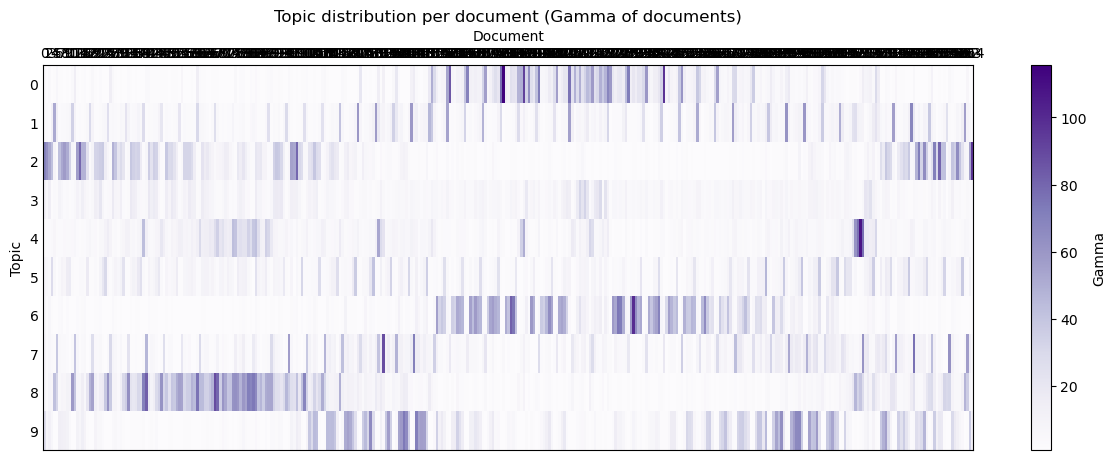

In [48]:
fig, ax = plt.subplots(figsize=(15,5))
im = ax.imshow(gamma_document, aspect='auto', cmap='Purples', interpolation='none')
ax.set_title('Topic distribution per document (Gamma of documents)')
ax.set_ylabel('Topic')
ax.set_xlabel('Document')
ax.set_yticks(np.arange(num_topics))
ax.set_xticks(np.arange(num_docs))
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.colorbar(im, ax=ax, label='Gamma')
plt.show()

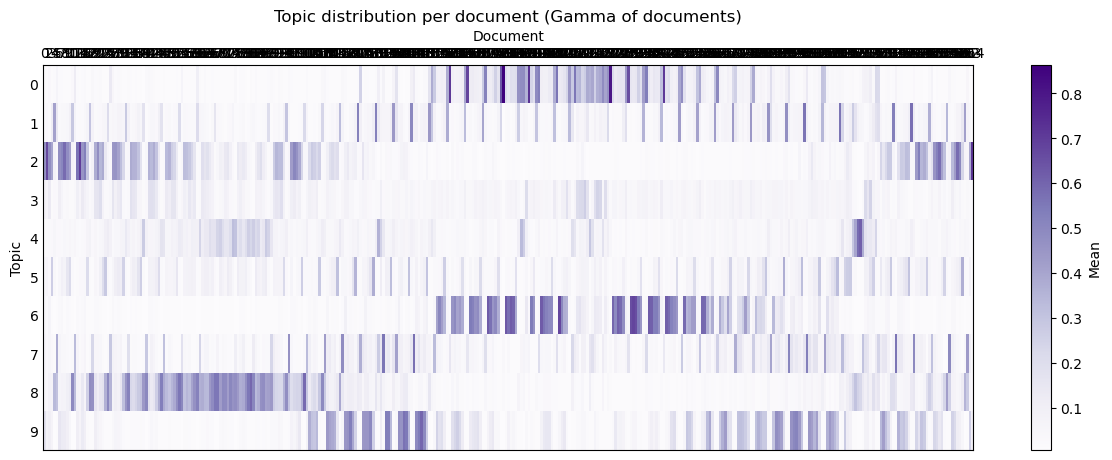

In [49]:
fig, ax = plt.subplots(figsize=(15,5))
im = ax.imshow(gamma_document_mean, aspect='auto', cmap='Purples', interpolation='none')
ax.set_title('Topic distribution per document (Gamma of documents)')
ax.set_ylabel('Topic')
ax.set_xlabel('Document')
ax.set_yticks(np.arange(num_topics))
ax.set_xticks(np.arange(num_docs))
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.colorbar(im, ax=ax, label='Mean')
plt.show()

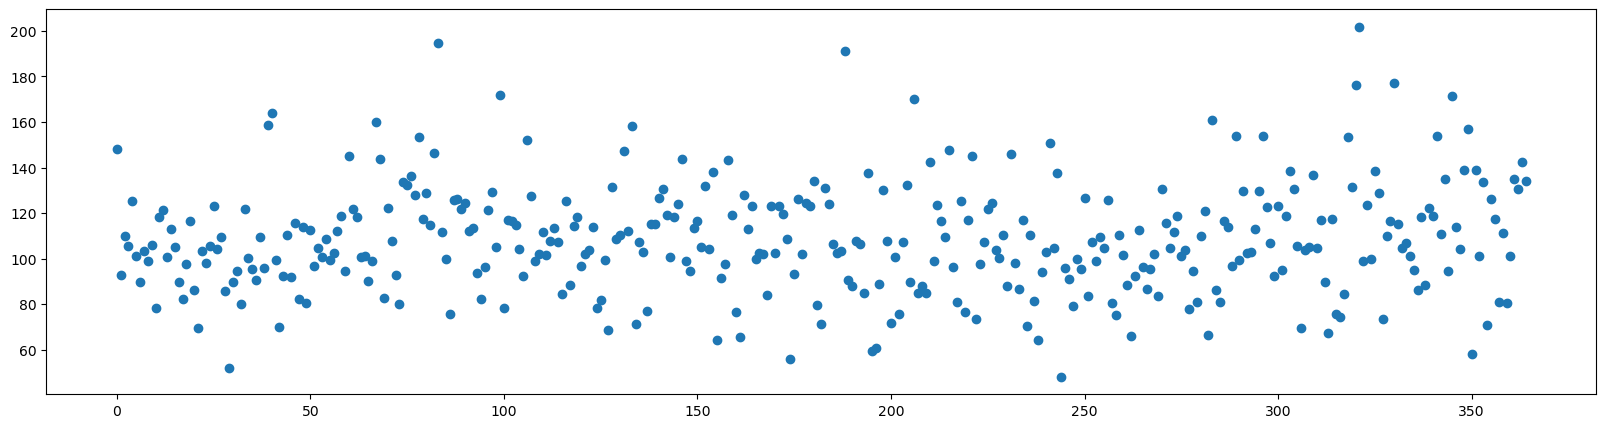

In [50]:
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(np.arange(num_days), gamma_document.sum(axis=0))

In [51]:
## entropy of dirichlet distribution
entropy = torch.distributions.dirichlet.Dirichlet(theta_dict['params']['alpha'].detach()).entropy()

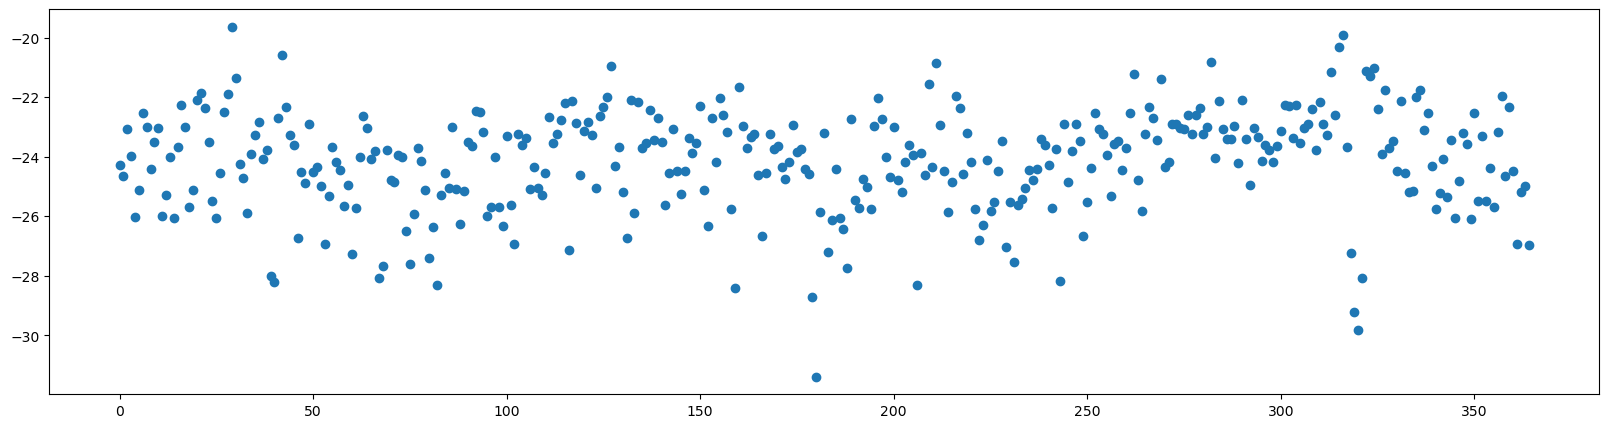

In [52]:
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(np.arange(num_days), entropy)

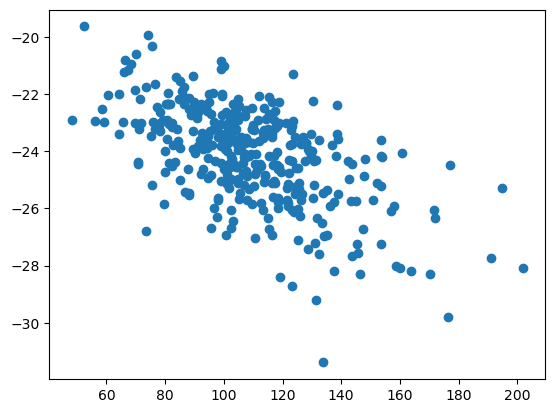

In [53]:
plt.scatter(gamma_document.sum(axis=0), entropy)

In [54]:
corpus = X_document.to(torch.float32)
corp_mean = corpus.mean(dim=1, keepdim=True)
inputs = corpus/corp_mean

In [55]:
model.encoder(inputs)['alpha'].log().softmax(1)[100]

tensor([0.0005, 0.0046, 0.4853, 0.0322, 0.0301, 0.0301, 0.0058, 0.0078, 0.2418,
        0.1618], grad_fn=<SelectBackward0>)

In [56]:
gamma_document_mean[:,100]

tensor([0.0129, 0.0188, 0.3872, 0.0899, 0.0391, 0.0408, 0.0139, 0.0200, 0.2378,
        0.1397])

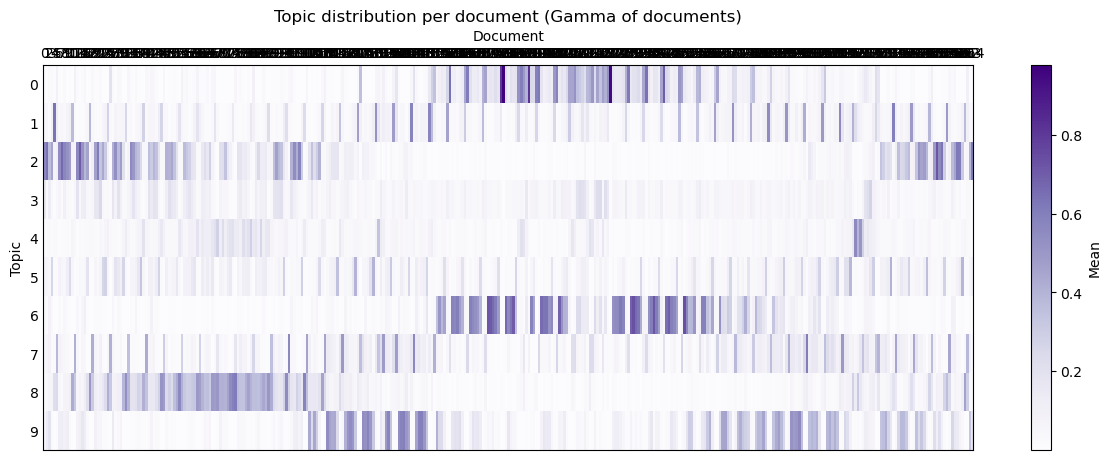

In [57]:
fig, ax = plt.subplots(figsize=(15,5))
im = ax.imshow(model.encoder(inputs)['alpha'].log().softmax(1).detach().T, aspect='auto', cmap='Purples', interpolation='none')
ax.set_title('Topic distribution per document (Gamma of documents)')
ax.set_ylabel('Topic')
ax.set_xlabel('Document')
ax.set_yticks(np.arange(num_topics))
ax.set_xticks(np.arange(num_docs))
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.colorbar(im, ax=ax, label='Mean')
plt.show()